<a href="https://colab.research.google.com/github/aasifahmed23/AI-ML-/blob/main/Asif_Gesture_Recognition_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition - Asif
In this group project, we are going to develop a feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
Here we would try to build a 3D Conv model that will be able to predict the 5 gestures correctly <br>
Each gesture corresponds to a specific command:
    - Thumbs up:  Increase the volume
    - Thumbs down: Decrease the volume
    - Left swipe: 'Jump' backwards 10 seconds
    - Right swipe: 'Jump' forward 10 seconds  
    - Stop: Pause the movie

In [ ]:
# Library Imports
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
import time
from sys import getsizeof

In [ ]:
# Setting random Seed to 30
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [ ]:
# Open CV import
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
# Keras imports for model building
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [ ]:
project_folder='Project_data'

## 1) Generator Class
We create a generator class in order to preprocess the images of different dimensions(160x160, 120x120 and 100x100) as well as create a batch of video frames. Basically we  have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy. We may use Data augmentation as well in case the accuracy doesn't improve.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs


    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))


                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

## 2) Modelling
Here we create a 3D convolution model using `Conv3D` and `MaxPooling3D`. We use `TimeDistributed` while building a Conv2D + RNN model. The last layer is the softmax with 5 outputs correcponding to the five gestures. Our design aim  is reasonable accuracy and less memory footprint of the model.

### Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### Sample Cropping

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=3,num_epochs=1)

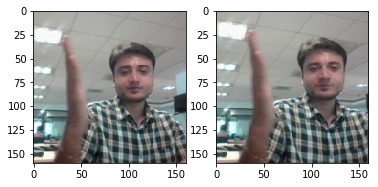

In [ ]:
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

## 3) Ablation Experiments

### 3a) Ablation Run for impact of Image resolution, number of frames to use and batch_size on GPU Memory Utilization

In this block, we read the folder names for training and validation. We also set the `batch_size` here. The batch size is set in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
#conv_3d1_model.summary()
#conv_3d1.train_model(conv_3d1_model)

We get ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc.
- Hence we need to feed images below 160x160 resolution
- Batch size should be between 15 to 40
- Number of frames should be around half of the batch size.

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


### 3b) Ablation Run for impact of Image resolution, number of frames to use and batch_size on Training time

Here we had used
- image resolutions (100x100, 120x120 and 160x160)
- frames_to_sample as 16 and 30
- batch sizes 10,30,40 and 60

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
67/67 [==============================] - 39s 589ms/step - loss: 1.6556 - categorical_accuracy: 0.3960 - val_loss: 1.4326 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-06-2815_20_13.352950/model-00001-1.65990-0.39668-1.43264-0.50000.h5
Epoch 2/3
67/67 [==============================] - 35s 522ms/step - loss: 1.2440 - categorical_accuracy: 0.5150 - val_loss: 1.6575 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-06-2815_20_13.352950/model-00002-1.24200-0.52036-1.65749-0.42000.h5
Epoch 3/3
67/67 [==============================] - 36s 544ms/step - loss: 1.0888 - categorical_accuracy: 0.5801 - val_loss: 1.3127 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-06-2815_20_13.352950/model-00003-1.08843-0.57919-1.31270-0.54000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
67/67 [==============================] - 70s 1s/step - loss: 1.7762 - categorical_accuracy: 0.3781 - val_loss: 1.6016 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-06-2815_22_08.873462/model-00001-1.77082-0.37858-1.60164-0.47000.h5
Epoch 2/3
67/67 [==============================] - 62s 920ms/step - loss: 1.4269 - categorical_accuracy: 0.4408 - val_loss: 1.5980 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-06-2815_22_08.873462/model-00002-1.43388-0.44193-1.59796-0.50000.h5
Epoch 3/3
67/67 [==============================] - 63s 944ms/step - loss: 1.1543 - categorical_accuracy: 0.5447 - val_loss: 1.0218 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-06-2815_22_08.873462/model-00003-1.16340-0.53997-1.02176-0.63000.h5


###### Increasing frames_to_sample increases training time per epoch, also the validation accuracy didn't improve here.

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
23/23 [==============================] - 43s 2s/step - loss: 1.6007 - categorical_accuracy: 0.4054 - val_loss: 1.7752 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-06-2815_25_30.021874/model-00001-1.61971-0.39517-1.77525-0.48000.h5
Epoch 2/3
23/23 [==============================] - 31s 1s/step - loss: 1.1283 - categorical_accuracy: 0.5592 - val_loss: 1.3896 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-06-2815_25_30.021874/model-00002-1.14215-0.55505-1.38956-0.52000.h5
Epoch 3/3
23/23 [==============================] - 32s 1s/step - loss: 0.9285 - categorical_accuracy: 0.6304 - val_loss: 1.1360 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-06-2815_25_30.021874/model-00003-0.93331-0.62896-1.13599-0.57000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
23/23 [==============================] - 73s 3s/step - loss: 1.6835 - categorical_accuracy: 0.3894 - val_loss: 2.1225 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-06-2815_27_22.468258/model-00001-1.71837-0.37858-2.12249-0.34000.h5
Epoch 2/3
23/23 [==============================] - 57s 2s/step - loss: 1.2377 - categorical_accuracy: 0.5395 - val_loss: 1.1052 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-06-2815_27_22.468258/model-00002-1.19905-0.54751-1.10523-0.57000.h5
Epoch 3/3
23/23 [==============================] - 60s 3s/step - loss: 1.0789 - categorical_accuracy: 0.5830 - val_loss: 2.8156 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_init_2020-06-2815_27_22.468258/model-00003-1.07195-0.59276-2.81557-0.39000.h5


###### Increasing batch size increases training time per epoch, also the validation accuracy were improved here.

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
17/17 [==============================] - 45s 3s/step - loss: 1.6335 - categorical_accuracy: 0.3702 - val_loss: 2.0799 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-06-2815_30_42.011628/model-00001-1.63959-0.36652-2.07994-0.39000.h5
Epoch 2/3
17/17 [==============================] - 29s 2s/step - loss: 1.0907 - categorical_accuracy: 0.5858 - val_loss: 1.7539 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-06-2815_30_42.011628/model-00002-1.09615-0.58522-1.75387-0.47000.h5
Epoch 3/3
17/17 [==============================] - 34s 2s/step - loss: 0.8191 - categorical_accuracy: 0.6732 - val_loss: 1.0115 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-06-2815_30_42.011628/model-00003-0.82504-0.67270-1.01146-0.58000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
17/17 [==============================] - 82s 5s/step - loss: 1.5768 - categorical_accuracy: 0.4197 - val_loss: 1.7942 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-06-2815_32_39.160581/model-00001-1.58002-0.41931-1.79423-0.43000.h5
Epoch 2/3
17/17 [==============================] - 56s 3s/step - loss: 1.0363 - categorical_accuracy: 0.5981 - val_loss: 1.0697 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-06-2815_32_39.160581/model-00002-1.04319-0.59578-1.06971-0.60000.h5
Epoch 3/3
17/17 [==============================] - 60s 4s/step - loss: 0.8510 - categorical_accuracy: 0.6790 - val_loss: 1.0594 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-2815_32_39.160581/model-00003-0.84858-0.68175-1.05944-0.61000.h5


###### Increasing batch size increases training time per epoch, also the validation accuracy were improved here.

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
12/12 [==============================] - 53s 4s/step - loss: 1.7049 - categorical_accuracy: 0.3711 - val_loss: 1.3682 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-06-2815_36_07.109513/model-00001-1.74708-0.37406-1.36816-0.54000.h5
Epoch 2/3
12/12 [==============================] - 29s 2s/step - loss: 1.0171 - categorical_accuracy: 0.5850 - val_loss: 1.0921 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-06-2815_36_07.109513/model-00002-1.01286-0.60483-1.09213-0.56000.h5
Epoch 3/3
12/12 [==============================] - 33s 3s/step - loss: 1.0086 - categorical_accuracy: 0.6331 - val_loss: 0.9846 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-2815_36_07.109513/model-00003-0.96998-0.63047-0.98455-0.61000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
12/12 [==============================] - 89s 7s/step - loss: 1.6580 - categorical_accuracy: 0.3669 - val_loss: 1.6322 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-06-2815_38_13.673627/model-00001-1.68056-0.36953-1.63217-0.41000.h5
Epoch 2/3
12/12 [==============================] - 54s 5s/step - loss: 1.2518 - categorical_accuracy: 0.5542 - val_loss: 1.0856 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-06-2815_38_13.673627/model-00002-1.13243-0.57164-1.08558-0.55000.h5
Epoch 3/3
12/12 [==============================] - 59s 5s/step - loss: 0.9789 - categorical_accuracy: 0.6261 - val_loss: 1.0153 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-06-2815_38_13.673627/model-00003-0.98257-0.62293-1.01535-0.58000.h5


#### For image size 100x100 there weren't any issues related to ResourceExhaustedError/OOM

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
67/67 [==============================] - 36s 539ms/step - loss: 1.6832 - categorical_accuracy: 0.3969 - val_loss: 1.2088 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2815_41_53.060653/model-00001-1.69638-0.39065-1.20882-0.45000.h5
Epoch 2/3
67/67 [==============================] - 29s 434ms/step - loss: 1.2891 - categorical_accuracy: 0.5035 - val_loss: 0.9193 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-06-2815_41_53.060653/model-00002-1.28535-0.50528-0.91929-0.64000.h5
Epoch 3/3
67/67 [==============================] - 34s 503ms/step - loss: 1.0637 - categorical_accuracy: 0.5796 - val_loss: 1.3596 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-06-2815_41_53.060653/model-00003-1.05158-0.58220-1.35961-0.49000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
67/67 [==============================] - 66s 983ms/step - loss: 1.6060 - categorical_accuracy: 0.4069 - val_loss: 1.3476 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-06-2815_43_41.120387/model-00001-1.61731-0.40422-1.34763-0.46000.h5
Epoch 2/3
67/67 [==============================] - 56s 838ms/step - loss: 1.2736 - categorical_accuracy: 0.5099 - val_loss: 1.3208 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-06-2815_43_41.120387/model-00002-1.27839-0.50830-1.32076-0.55000.h5
Epoch 3/3
67/67 [==============================] - 62s 926ms/step - loss: 1.1221 - categorical_accuracy: 0.5558 - val_loss: 1.0298 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-06-2815_43_41.120387/model-00003-1.11540-0.55807-1.02979-0.66000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
23/23 [==============================] - 43s 2s/step - loss: 1.7048 - categorical_accuracy: 0.3696 - val_loss: 1.9389 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-06-2815_46_56.989744/model-00001-1.69115-0.37104-1.93892-0.36000.h5
Epoch 2/3
23/23 [==============================] - 27s 1s/step - loss: 1.1461 - categorical_accuracy: 0.5520 - val_loss: 0.9221 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-06-2815_46_56.989744/model-00002-1.15630-0.54751-0.92208-0.66000.h5
Epoch 3/3
23/23 [==============================] - 33s 1s/step - loss: 0.9419 - categorical_accuracy: 0.6507 - val_loss: 1.1593 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-06-2815_46_56.989744/model-00003-0.92951-0.65008-1.15931-0.63000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
23/23 [==============================] - 76s 3s/step - loss: 1.6432 - categorical_accuracy: 0.3769 - val_loss: 2.4192 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-06-2815_48_52.138717/model-00001-1.66466-0.37858-2.41922-0.40000.h5
Epoch 2/3
23/23 [==============================] - 55s 2s/step - loss: 1.0675 - categorical_accuracy: 0.5732 - val_loss: 1.2062 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-06-2815_48_52.138717/model-00002-1.08914-0.55656-1.20616-0.60000.h5
Epoch 3/3
23/23 [==============================] - 62s 3s/step - loss: 0.8571 - categorical_accuracy: 0.6594 - val_loss: 1.2000 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-2815_48_52.138717/model-00003-0.85551-0.65913-1.20003-0.61000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
17/17 [==============================] - 47s 3s/step - loss: 1.6144 - categorical_accuracy: 0.4069 - val_loss: 2.4542 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2020-06-2815_52_18.607558/model-00001-1.62305-0.40724-2.45422-0.41000.h5
Epoch 2/3
17/17 [==============================] - 25s 1s/step - loss: 1.0294 - categorical_accuracy: 0.5906 - val_loss: 1.1221 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-06-2815_52_18.607558/model-00002-1.03263-0.59125-1.12213-0.57000.h5
Epoch 3/3
17/17 [==============================] - 33s 2s/step - loss: 0.7950 - categorical_accuracy: 0.6737 - val_loss: 0.9322 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-06-2815_52_18.607558/model-00003-0.79321-0.67421-0.93222-0.64000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
17/17 [==============================] - 83s 5s/step - loss: 1.6040 - categorical_accuracy: 0.4094 - val_loss: 1.2950 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-06-2815_54_18.014307/model-00001-1.61379-0.40875-1.29502-0.56000.h5
Epoch 2/3
17/17 [==============================] - 53s 3s/step - loss: 0.9911 - categorical_accuracy: 0.6201 - val_loss: 0.9329 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2020-06-2815_54_18.014307/model-00002-0.98896-0.62142-0.93287-0.67000.h5
Epoch 3/3
17/17 [==============================] - 61s 4s/step - loss: 0.7899 - categorical_accuracy: 0.7037 - val_loss: 1.5659 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2020-06-2815_54_18.014307/model-00003-0.79215-0.70287-1.56595-0.59000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Epoch 1/3
12/12 [==============================] - 53s 4s/step - loss: 1.7282 - categorical_accuracy: 0.3425 - val_loss: 1.6896 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-06-2815_57_52.205204/model-00001-1.74471-0.36953-1.68961-0.44000.h5
Epoch 2/3
12/12 [==============================] - 24s 2s/step - loss: 1.2801 - categorical_accuracy: 0.5193 - val_loss: 1.5858 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-06-2815_57_52.205204/model-00002-1.22258-0.53394-1.58576-0.42000.h5
Epoch 3/3
12/12 [==============================] - 32s 3s/step - loss: 1.1280 - categorical_accuracy: 0.5794 - val_loss: 1.3334 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-06-2815_57_52.205204/model-00003-1.02931-0.59879-1.33344-0.49000.h5


###### Increasing image size also increases the number of parameters,training time per epoch, however the validation accuracy were improved here.

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())

Total Params: 900805


In [ ]:
#conv_3d1.train_model(conv_3d1_model)

 #### OOM error is observed by setting batch size to 60 for a 120x120 image

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
67/67 [==============================] - 42s 632ms/step - loss: 1.6566 - categorical_accuracy: 0.3995 - val_loss: 1.2528 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2815_59_58.906710/model-00001-1.66562-0.39668-1.25277-0.45000.h5
Epoch 2/3
67/67 [==============================] - 30s 444ms/step - loss: 1.2683 - categorical_accuracy: 0.4960 - val_loss: 1.0517 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-06-2815_59_58.906710/model-00002-1.27166-0.49774-1.05168-0.57000.h5
Epoch 3/3
67/67 [==============================] - 38s 566ms/step - loss: 1.0273 - categorical_accuracy: 0.6084 - val_loss: 0.8556 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-06-2815_59_58.906710/model-00003-1.02078-0.60784-0.85561-0.69000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
67/67 [==============================] - 74s 1s/step - loss: 1.5827 - categorical_accuracy: 0.3875 - val_loss: 1.2890 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-06-2816_02_02.479186/model-00001-1.59390-0.38462-1.28901-0.56000.h5
Epoch 2/3
67/67 [==============================] - 59s 887ms/step - loss: 1.1884 - categorical_accuracy: 0.5234 - val_loss: 1.1204 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-06-2816_02_02.479186/model-00002-1.19697-0.52187-1.12041-0.55000.h5
Epoch 3/3
67/67 [==============================] - 70s 1s/step - loss: 1.0037 - categorical_accuracy: 0.6344 - val_loss: 1.0055 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2020-06-2816_02_02.479186/model-00003-0.97978-0.64103-1.00554-0.59000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 48s 2s/step - loss: 1.5286 - categorical_accuracy: 0.4358 - val_loss: 1.5051 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-06-2816_05_41.408932/model-00001-1.54738-0.42685-1.50506-0.53000.h5
Epoch 2/3
23/23 [==============================] - 27s 1s/step - loss: 1.0135 - categorical_accuracy: 0.6083 - val_loss: 1.2398 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-06-2816_05_41.408932/model-00002-0.96128-0.63198-1.23983-0.55000.h5
Epoch 3/3
23/23 [==============================] - 38s 2s/step - loss: 0.9505 - categorical_accuracy: 0.6367 - val_loss: 0.8008 - val_categorical_accuracy: 0.7400

Epoch 00003: saving model to model_init_2020-06-2816_05_41.408932/model-00003-0.90244-0.64857-0.80080-0.74000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())

Total Params: 1736389


In [ ]:
#conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
17/17 [==============================] - 52s 3s/step - loss: 1.5518 - categorical_accuracy: 0.3936 - val_loss: 1.5664 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-06-2816_07_52.328494/model-00001-1.55456-0.39367-1.56643-0.49000.h5
Epoch 2/3
17/17 [==============================] - 27s 2s/step - loss: 1.0235 - categorical_accuracy: 0.6034 - val_loss: 0.8558 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2020-06-2816_07_52.328494/model-00002-1.02641-0.60332-0.85582-0.70000.h5
Epoch 3/3
17/17 [==============================] - 37s 2s/step - loss: 0.8538 - categorical_accuracy: 0.6541 - val_loss: 0.8269 - val_categorical_accuracy: 0.7300

Epoch 00003: saving model to model_init_2020-06-2816_07_52.328494/model-00003-0.85749-0.65309-0.82695-0.73000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())

Total Params: 1736389


In [ ]:
#conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())

Total Params: 1736389


In [ ]:
#conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())

Total Params: 1736389


In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### While using larger image size and larger batch size resulted in OOM Error.

![image.png](attachment:image.png)

#### Based on the above experiments we may proceed with
- batch size of 15-40 and
- changing the resolution and number of image per sequence based on the device memory constraints
- To create lightweight models we may create models whose memory footprint should be less than 50 MB.

### Plotting Function

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## 4) Model Building Phase

 ### Model 1 - Conv 3D Model without Data Augmentation.

In [ ]:
class ModelConv3D1(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_101 (Conv3D)          (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_101 (Activation)  (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_151 (Bat (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_101 (MaxPoolin (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_102 (Activation)  (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_152 (Bat (None, 10, 80, 80, 32)    128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)
end=time.time()
end-start

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 65s 4s/step - loss: 1.6437 - categorical_accuracy: 0.4010 - val_loss: 4.0636 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-06-2816_10_08.222776/model-00001-1.63777-0.40121-4.06360-0.39000.h5
Epoch 2/15
17/17 [==============================] - 33s 2s/step - loss: 0.9455 - categorical_accuracy: 0.6092 - val_loss: 2.8897 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-06-2816_10_08.222776/model-00002-0.94032-0.61237-2.88969-0.47000.h5
Epoch 3/15
17/17 [==============================] - 47s 3s/step - loss: 0.7309 - categorical_accuracy: 0.7248 - val_loss: 1.5215 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-06-2816_10_08.222776/model-00003-0.73116-0.72549-1.52153-0.50000.h5
Epoch 4/15
17/17 [==============================] - 46s 3s/step - loss: 0.5072 - categorical_accuracy: 0.8205 - val_loss: 0.7304 - val_categoric

726.2287104129791

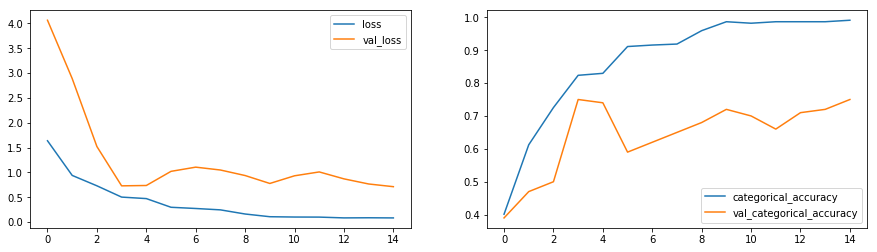

In [ ]:
plot(history_model1)

##### We need to perform data augmentation is required since the is  Model Overfitting

## Model 2 - Conv 3D with Data Augmentation[(3,3,3) filter & 160x160 image resolution ]

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_105 (Conv3D)          (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_105 (Activation)  (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_157 (Bat (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_105 (MaxPoolin (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_106 (Activation)  (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_158 (Bat (None, 10, 80, 80, 32)    128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)
end=time.time()
end-start

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 146s 4s/step - loss: 1.8968 - categorical_accuracy: 0.3988 - val_loss: 11.4725 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-06-2816_22_15.582533/model-00001-1.91010-0.39216-11.47249-0.23000.h5
Epoch 2/25
34/34 [==============================] - 118s 3s/step - loss: 1.3905 - categorical_accuracy: 0.5250 - val_loss: 3.2369 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_init_2020-06-2816_22_15.582533/model-00002-1.37373-0.52564-3.23691-0.35000.h5
Epoch 3/25
34/34 [==============================] - 137s 4s/step - loss: 1.1269 - categorical_accuracy: 0.5795 - val_loss: 1.6115 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-06-2816_22_15.582533/model-00003-1.13923-0.58145-1.61150-0.49000.h5
Epoch 4/25
34/34 [==============================] - 136s 4s/step - loss: 1.2943 - categorical_accuracy: 0.5563 - val_loss: 7.7256 - val_cat

3428.439705848694

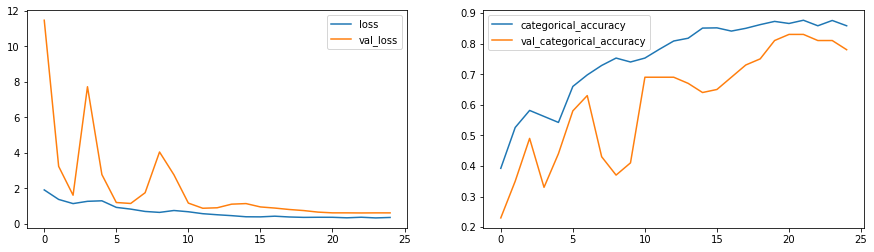

In [ ]:
plot(history_model2)

##### We get a best validation accuracy of 78% and training accuracy of 85%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 - Conv 3D with Data Augmentation[(2,2,2) filter & 120x120 image resolution ]

In [ ]:
class ModelConv3D3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_109 (Conv3D)          (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_109 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_163 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_109 (MaxPoolin (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_110 (Conv3D)          (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_110 (Activation)  (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_164 (Bat (None, 8, 60, 60, 32)     128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)
end=time.time()
end-start

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 110s 5s/step - loss: 2.1484 - categorical_accuracy: 0.3403 - val_loss: 1.1873 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-06-2817_19_25.152135/model-00001-2.15179-0.33409-1.18735-0.55000.h5
Epoch 2/30
23/23 [==============================] - 82s 4s/step - loss: 1.4753 - categorical_accuracy: 0.5035 - val_loss: 0.9402 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2020-06-2817_19_25.152135/model-00002-1.52223-0.48416-0.94021-0.63000.h5
Epoch 3/30
23/23 [==============================] - 100s 4s/step - loss: 1.3880 - categorical_accuracy: 0.5300 - val_loss: 0.9379 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-06-2817_19_25.152135/model-00003-1.35249-0.53771-0.93795-0.69000.h5
Epoch 4/30
23/23 [==============================] - 99s 4s/step - loss: 1.1961 - categorical_accuracy: 0.5750 - val_loss: 0.8495 - val_categor

Epoch 30/30
23/23 [==============================] - 98s 4s/step - loss: 0.6167 - categorical_accuracy: 0.7918 - val_loss: 0.6024 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2020-06-2817_19_25.152135/model-00030-0.54278-0.80317-0.60241-0.77000.h5


2990.9598591327667

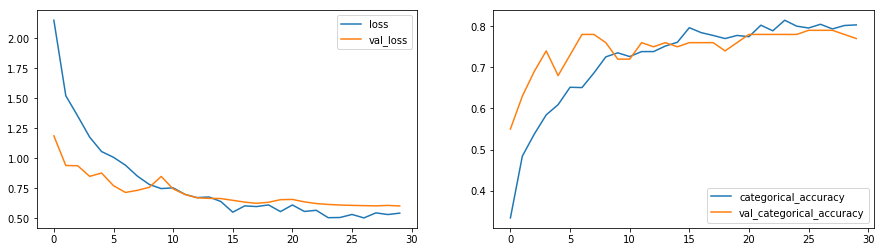

In [ ]:
plot(history_model3)

##### Model has a  best validation accuracy of 77% and training accuracy of 79.18% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - Conv 3D with Data Augmentation having 8 Conv Layers

In [ ]:
class ModelConv3D4(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_113 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_113 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_169 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_114 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_170 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_113 (MaxPoolin (None, 8, 60, 60, 16)     0         
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)
end=time.time()
end-start

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 110s 3s/step - loss: 2.0188 - categorical_accuracy: 0.3709 - val_loss: 10.4567 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-06-2818_09_18.486560/model-00001-1.98249-0.38009-10.45673-0.23000.h5
Epoch 2/30
34/34 [==============================] - 76s 2s/step - loss: 1.8442 - categorical_accuracy: 0.3911 - val_loss: 3.4035 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-06-2818_09_18.486560/model-00002-1.84524-0.38839-3.40353-0.49000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.4107 - categorical_accuracy: 0.4960 - val_loss: 1.3950 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-06-2818_09_18.486560/model-00003-1.39644-0.50000-1.39503-0.57000.h5
Epoch 4/30
34/34 [==============================] - 100s 3s/step - loss: 1.4273 - categorical_accuracy: 0.5026 - val_loss: 2.7736 - val_categ

34/34 [==============================] - 99s 3s/step - loss: 0.5650 - categorical_accuracy: 0.7800 - val_loss: 0.6813 - val_categorical_accuracy: 0.7000

Epoch 00029: saving model to model_init_2020-06-2818_09_18.486560/model-00029-0.52974-0.79110-0.68130-0.70000.h5
Epoch 30/30
34/34 [==============================] - 101s 3s/step - loss: 0.6198 - categorical_accuracy: 0.7682 - val_loss: 0.6690 - val_categorical_accuracy: 0.7100

Epoch 00030: saving model to model_init_2020-06-2818_09_18.486560/model-00030-0.61641-0.77074-0.66905-0.71000.h5


3047.0202100276947

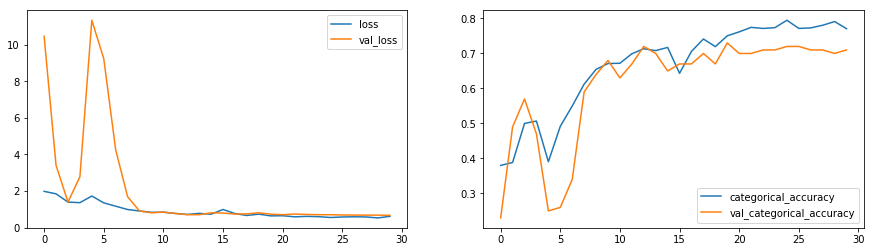

In [ ]:
plot(history_model4)

##### We get a best validation accuracy of 71%  and 76.8% Training Accuracy. Let's try adding dropouts at the convolution layers

## Model 5 - Eight layered Conv 3D with dropouts after Conv Layers

In [ ]:
class ModelConv3D5(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_121 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_121 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_179 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_122 (Conv3D)          (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_122 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_180 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_117 (MaxPoolin (None, 8, 60, 60, 16)     0         
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)
end=time.time()
end-start

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 110s 3s/step - loss: 1.8359 - categorical_accuracy: 0.3609 - val_loss: 1.7431 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2819_00_07.367616/model-00001-1.83208-0.36576-1.74308-0.45000.h5
Epoch 2/22
34/34 [==============================] - 77s 2s/step - loss: 1.3681 - categorical_accuracy: 0.4875 - val_loss: 1.2420 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-06-2819_00_07.367616/model-00002-1.32914-0.48718-1.24198-0.53000.h5
Epoch 3/22
34/34 [==============================] - 99s 3s/step - loss: 1.2229 - categorical_accuracy: 0.5541 - val_loss: 1.8221 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-06-2819_00_07.367616/model-00003-1.18932-0.55958-1.82205-0.41000.h5
Epoch 4/22
34/34 [==============================] - 101s 3s/step - loss: 1.0951 - categorical_accuracy: 0.5835 - val_loss: 1.3239 - val_categor

2231.345585823059

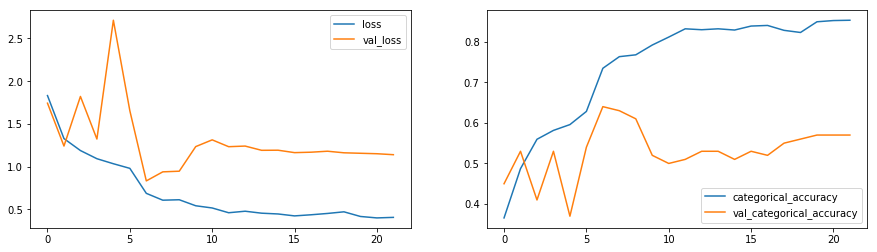

In [ ]:
plot(history_model5)

##### Validation accuracy reduces significantly to 57%, adding dropouts after conv3D resulted in loosing the useful features.

## Creating Lightweight Models
The preceding models had parameters ranging from 1 Million to 3.6 Million hence our next aim would be to make the model lightweight, We may adopt following Strategies to do so
- Reducing Dense layer Neurons from 256 to 128 and finally to 64.
- Successive reduction of Conv3D Layer Neurons by half.

## Model 6 - Reducing Dense layer Neurons from 256 to 128

In [ ]:
class ModelConv3D6(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_129 (Conv3D)          (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_129 (Activation)  (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_121 (MaxPoolin (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_130 (Conv3D)          (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_130 (Activation)  (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_190 (Bat (None, 8, 50, 50, 32)     128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)
end=time.time()
end-start

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 103s 3s/step - loss: 1.9440 - categorical_accuracy: 0.3304 - val_loss: 1.4092 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-06-2819_37_19.929099/model-00001-1.92775-0.33861-1.40920-0.50000.h5
Epoch 2/30
34/34 [==============================] - 77s 2s/step - loss: 1.2707 - categorical_accuracy: 0.5114 - val_loss: 1.1932 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-06-2819_37_19.929099/model-00002-1.24322-0.52413-1.19317-0.60000.h5
Epoch 3/30
34/34 [==============================] - 95s 3s/step - loss: 1.0855 - categorical_accuracy: 0.5677 - val_loss: 0.9572 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-06-2819_37_19.929099/model-00003-1.05558-0.57768-0.95718-0.65000.h5
Epoch 4/30
34/34 [==============================] - 95s 3s/step - loss: 0.9262 - categorical_accuracy: 0.6413 - val_loss: 0.9622 - val_categoric


Epoch 00029: saving model to model_init_2020-06-2819_37_19.929099/model-00029-0.41597-0.84691-0.77352-0.72000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.
Epoch 30/30
34/34 [==============================] - 96s 3s/step - loss: 0.4797 - categorical_accuracy: 0.8447 - val_loss: 0.7738 - val_categorical_accuracy: 0.7300

Epoch 00030: saving model to model_init_2020-06-2819_37_19.929099/model-00030-0.42152-0.85747-0.77383-0.73000.h5


2878.1875393390656

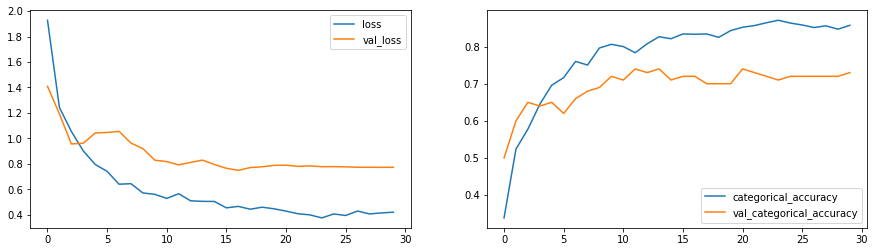

In [ ]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 73% while the training Accuracy was 84.47%

## Model 7 - Reducing Dense layer Neurons from 128 to 64

In [ ]:
class ModelConv3D7(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_133 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_133 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_195 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_125 (MaxPoolin (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_134 (Conv3D)          (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_134 (Activation)  (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_196 (Bat (None, 8, 60, 60, 32)     128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)
end=time.time()
end-start

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 107s 3s/step - loss: 1.9416 - categorical_accuracy: 0.3021 - val_loss: 1.4091 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2820_25_19.337228/model-00001-1.94812-0.29713-1.40905-0.45000.h5
Epoch 2/25
34/34 [==============================] - 82s 2s/step - loss: 1.3570 - categorical_accuracy: 0.4746 - val_loss: 1.0983 - val_categorical_accuracy: 0.5400

Epoch 00002: saving model to model_init_2020-06-2820_25_19.337228/model-00002-1.35237-0.47813-1.09831-0.54000.h5
Epoch 3/25
34/34 [==============================] - 98s 3s/step - loss: 1.1364 - categorical_accuracy: 0.5390 - val_loss: 0.9874 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-06-2820_25_19.337228/model-00003-1.12837-0.54827-0.98740-0.63000.h5
Epoch 4/25
34/34 [==============================] - 99s 3s/step - loss: 1.0621 - categorical_accuracy: 0.5743 - val_loss: 0.9266 - val_categoric

2505.13241147995

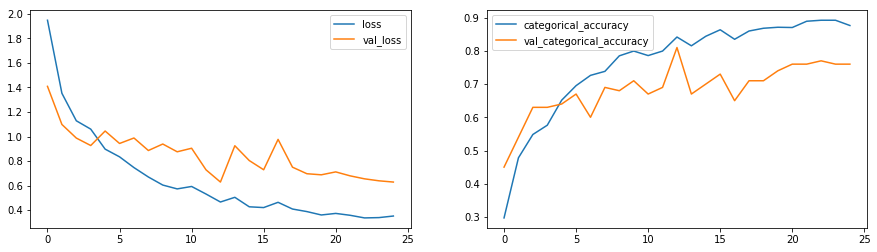

In [ ]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 76% while training Accuracy was 87.53%

## Model 8 - Successive reduction of Conv3D Layer Neurons by half.

In [ ]:
class ModelConv3D8(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_137 (Conv3D)          (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_137 (Activation)  (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_201 (Bat (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_129 (MaxPoolin (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_138 (Conv3D)          (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_138 (Activation)  (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_202 (Bat (None, 8, 60, 60, 16)     64        
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)
end=time.time()
end-start

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 106s 3s/step - loss: 1.9592 - categorical_accuracy: 0.3035 - val_loss: 1.4132 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-06-2821_07_05.725323/model-00001-1.95996-0.30694-1.41316-0.43000.h5
Epoch 2/30
34/34 [==============================] - 79s 2s/step - loss: 1.5362 - categorical_accuracy: 0.4316 - val_loss: 1.2387 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-06-2821_07_05.725323/model-00002-1.50140-0.43816-1.23868-0.49000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.3597 - categorical_accuracy: 0.4857 - val_loss: 1.1715 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-06-2821_07_05.725323/model-00003-1.33630-0.48944-1.17150-0.55000.h5
Epoch 4/30
34/34 [==============================] - 99s 3s/step - loss: 1.1978 - categorical_accuracy: 0.5272 - val_loss: 1.0848 - val_categoric

Epoch 30/30
34/34 [==============================] - 98s 3s/step - loss: 0.5564 - categorical_accuracy: 0.7892 - val_loss: 0.7837 - val_categorical_accuracy: 0.6700

Epoch 00030: saving model to model_init_2020-06-2821_07_05.725323/model-00030-0.54497-0.79638-0.78366-0.67000.h5


2996.8982491493225

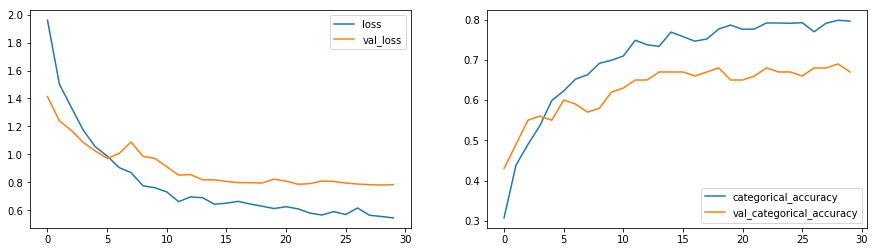

In [ ]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 67%

##  Model 9 - CNN- LSTM Model

In [ ]:
class RNNCNN1(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [ ]:
start=time.time()
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)
end=time.time()
end-start

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 118s 3s/step - loss: 1.4576 - categorical_accuracy: 0.3631 - val_loss: 1.2935 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-06-2821_57_08.463554/model-00001-1.44381-0.36802-1.29352-0.48000.h5
Epoch 2/20
34/34 [==============================] - 91s 3s/step - loss: 1.2245 - categorical_accuracy: 0.4919 - val_loss: 1.3489 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-06-2821_57_08.463554/model-00002-1.23937-0.48341-1.34893-0.41000.h5
Epoch 3/20
34/34 [==============================] - 111s 3s/step - loss: 1.1075 - categorical_accuracy: 0.5386 - val_loss: 0.9563 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2020-06-2821_57_08.463554/model-00003-1.10334-0.54374-0.95635-0.62000.h5
Epoch 4/20
34/34 [==============================] - 110s 3s/step - loss: 0.9886 - categorical_accuracy: 0.6052 - val_loss: 1.4215 - val_catego

2230.364531517029

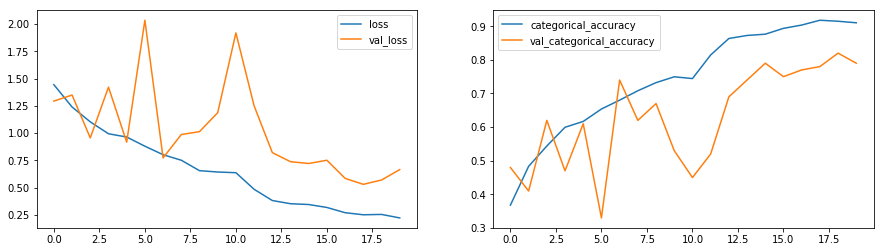

In [ ]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 79%

### As we see more cases of overfitting, we apply data augmentation with slight rotation and rerun the same set of models again(Models 2 to 9).

# More Augmentation

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs


    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

## Model 10- Conv 3D with More Data Augmentation(3,3,3) filter & 160x160 image resolution
## (similar to Model 2)

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_141 (Conv3D)          (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_141 (Activation)  (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_212 (Bat (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_133 (MaxPoolin (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_142 (Conv3D)          (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_142 (Activation)  (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_213 (Bat (None, 10, 80, 80, 32)    128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)
end=time.time()
end-start

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 149s 4s/step - loss: 2.0398 - categorical_accuracy: 0.3381 - val_loss: 1.2645 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-06-2822_34_20.154392/model-00001-2.03822-0.34238-1.26452-0.52000.h5
Epoch 2/30
34/34 [==============================] - 119s 4s/step - loss: 1.4643 - categorical_accuracy: 0.5092 - val_loss: 0.9745 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2020-06-2822_34_20.154392/model-00002-1.45724-0.51357-0.97452-0.63000.h5
Epoch 3/30
34/34 [==============================] - 140s 4s/step - loss: 1.4728 - categorical_accuracy: 0.5044 - val_loss: 0.9446 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-06-2822_34_20.154392/model-00003-1.40920-0.51282-0.94458-0.61000.h5
Epoch 4/30
34/34 [==============================] - 140s 4s/step - loss: 1.2276 - categorical_accuracy: 0.5820 - val_loss: 0.9040 - val_categ

Epoch 30/30
34/34 [==============================] - 140s 4s/step - loss: 0.4046 - categorical_accuracy: 0.8554 - val_loss: 0.6183 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2020-06-2822_34_20.154392/model-00030-0.40169-0.85596-0.61826-0.87000.h5


4220.943185091019

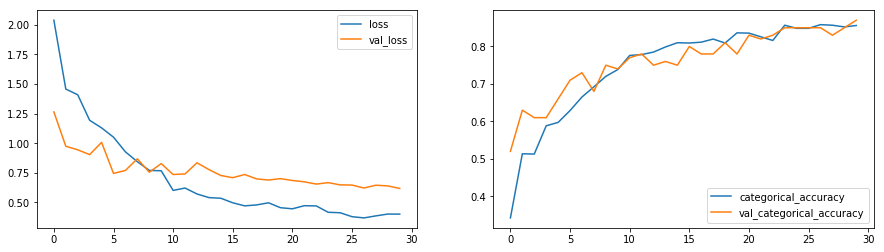

In [ ]:
plot(history_model10)

The Validation Accuracy and Training accuracy are 87% and 85.4% respectively after applying more data augmentation.

## Model 11- Conv 3D with More Data Augmentation(2,2,2) filter & 120x120 image resolution
## (similar to Model 3)

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_145 (Conv3D)          (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_145 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_218 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_137 (MaxPoolin (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_146 (Conv3D)          (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_146 (Activation)  (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_219 (Bat (None, 8, 60, 60, 32)     128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)
end=time.time()
end-start

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 111s 5s/step - loss: 2.2395 - categorical_accuracy: 0.3255 - val_loss: 1.5327 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-06-2823_44_42.387121/model-00001-2.28347-0.31222-1.53270-0.47000.h5
Epoch 2/30
23/23 [==============================] - 80s 3s/step - loss: 1.6915 - categorical_accuracy: 0.4360 - val_loss: 1.1154 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-06-2823_44_42.387121/model-00002-1.63618-0.44646-1.11540-0.61000.h5
Epoch 3/30
23/23 [==============================] - 101s 4s/step - loss: 1.3784 - categorical_accuracy: 0.5309 - val_loss: 0.8862 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2020-06-2823_44_42.387121/model-00003-1.36874-0.52564-0.88621-0.68000.h5
Epoch 4/30
23/23 [==============================] - 100s 4s/step - loss: 1.2772 - categorical_accuracy: 0.5671 - val_loss: 0.8531 - val_catego

23/23 [==============================] - 100s 4s/step - loss: 0.7513 - categorical_accuracy: 0.7164 - val_loss: 0.7272 - val_categorical_accuracy: 0.7400

Epoch 00029: saving model to model_init_2020-06-2823_44_42.387121/model-00029-0.68538-0.74434-0.72725-0.74000.h5
Epoch 30/30
23/23 [==============================] - 100s 4s/step - loss: 0.7079 - categorical_accuracy: 0.7246 - val_loss: 0.7272 - val_categorical_accuracy: 0.7400

Epoch 00030: saving model to model_init_2020-06-2823_44_42.387121/model-00030-0.67506-0.73982-0.72724-0.74000.h5


3044.128303527832

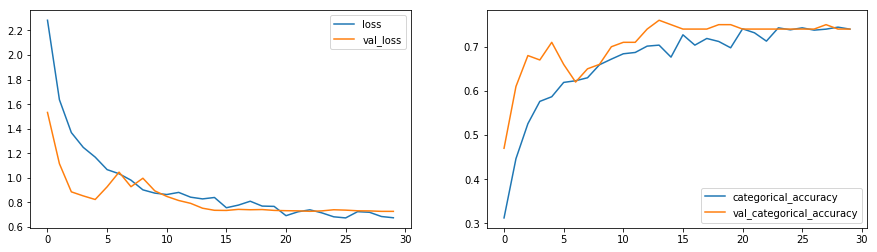

In [ ]:
plot(history_model11)

The Validation Accuracy and Training accuracy are 74% and 72% respectively after applying more data augmentation.

## Model 12 - Conv 3D with More Data Augmentation having 8 Conv Layers
## (similar to Model 4)

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_149 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_149 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_224 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_150 (Conv3D)          (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_150 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_225 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_141 (MaxPoolin (None, 8, 60, 60, 16)     0         
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)
end=time.time()
end-start

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 109s 3s/step - loss: 2.1032 - categorical_accuracy: 0.3488 - val_loss: 1.8618 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-06-2900_35_28.527912/model-00001-2.11553-0.34087-1.86177-0.37000.h5
Epoch 2/30
34/34 [==============================] - 72s 2s/step - loss: 1.5997 - categorical_accuracy: 0.4415 - val_loss: 1.3370 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-06-2900_35_28.527912/model-00002-1.59122-0.44419-1.33699-0.53000.h5
Epoch 3/30
34/34 [==============================] - 102s 3s/step - loss: 1.5125 - categorical_accuracy: 0.5040 - val_loss: 1.5260 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-06-2900_35_28.527912/model-00003-1.50035-0.50830-1.52603-0.54000.h5
Epoch 4/30
34/34 [==============================] - 103s 3s/step - loss: 1.3085 - categorical_accuracy: 0.5703 - val_loss: 1.1568 - val_catego

Epoch 30/30
34/34 [==============================] - 102s 3s/step - loss: 0.3198 - categorical_accuracy: 0.8841 - val_loss: 0.6852 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2020-06-2900_35_28.527912/model-00030-0.32243-0.88537-0.68521-0.77000.h5


3089.0915360450745

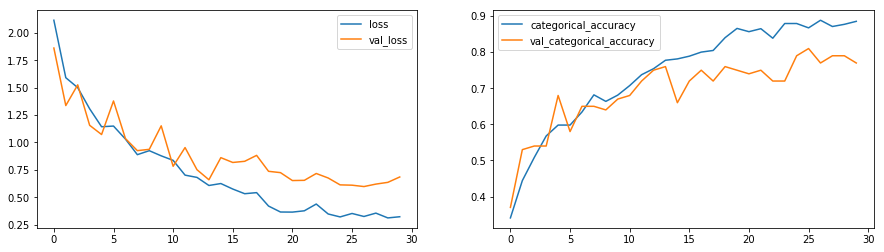

In [ ]:
plot(history_model12)

The Validation Accuracy and Training accuracy are 77% and 88% respectively after applying more data augmentation.

## Model 13 - Eight layered Conv 3D with dropouts after Conv Layers and Additional Augmentation(similar to Model 5)

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_157 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_157 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_234 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_158 (Conv3D)          (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_158 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_235 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_145 (MaxPoolin (None, 8, 60, 60, 16)     0         
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)
end=time.time()
end-start

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 112s 3s/step - loss: 2.0717 - categorical_accuracy: 0.2873 - val_loss: 2.3859 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-06-2901_26_59.764344/model-00001-2.04392-0.29035-2.38592-0.25000.h5
Epoch 2/25
34/34 [==============================] - 70s 2s/step - loss: 1.6285 - categorical_accuracy: 0.4165 - val_loss: 2.9406 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-06-2901_26_59.764344/model-00002-1.61389-0.41855-2.94063-0.25000.h5
Epoch 3/25
34/34 [==============================] - 102s 3s/step - loss: 1.3566 - categorical_accuracy: 0.5044 - val_loss: 3.5386 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2020-06-2901_26_59.764344/model-00003-1.35767-0.50452-3.53859-0.30000.h5
Epoch 4/25
34/34 [==============================] - 102s 3s/step - loss: 1.2040 - categorical_accuracy: 0.5589 - val_loss: 3.1714 - val_catego

2581.0757393836975

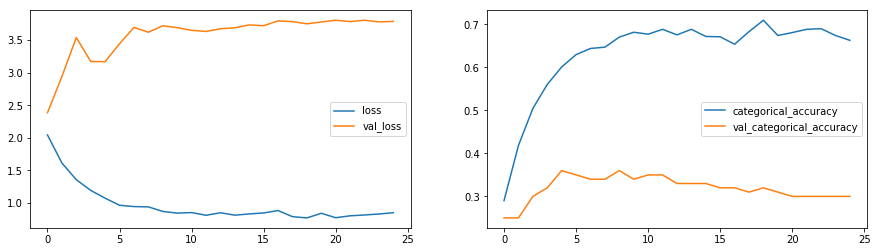

In [ ]:
plot(history_model13)

The Validation Accuracy and Training accuracy are 30% and 65% respectively after applying more data augmentation.

## Model 14 - Reducing Dense layer Neurons from 256 to 128 with additional Augmentation
## (Similar to model 6)

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_165 (Conv3D)          (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_165 (Activation)  (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_244 (Bat (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_149 (MaxPoolin (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_166 (Conv3D)          (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_166 (Activation)  (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_245 (Bat (None, 8, 50, 50, 32)     128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)
end=time.time()
end-start

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 104s 3s/step - loss: 1.8114 - categorical_accuracy: 0.3554 - val_loss: 1.4387 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-06-2902_10_02.229089/model-00001-1.84034-0.34766-1.43872-0.51000.h5
Epoch 2/30
34/34 [==============================] - 72s 2s/step - loss: 1.2662 - categorical_accuracy: 0.5110 - val_loss: 1.3191 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-06-2902_10_02.229089/model-00002-1.27563-0.51131-1.31911-0.55000.h5
Epoch 3/30
34/34 [==============================] - 98s 3s/step - loss: 1.0568 - categorical_accuracy: 0.5916 - val_loss: 1.0636 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-06-2902_10_02.229089/model-00003-1.04468-0.59804-1.06360-0.64000.h5
Epoch 4/30
34/34 [==============================] - 97s 3s/step - loss: 0.9673 - categorical_accuracy: 0.6284 - val_loss: 1.0264 - val_categoric


Epoch 00029: saving model to model_init_2020-06-2902_10_02.229089/model-00029-0.39399-0.85747-0.74709-0.76000.h5
Epoch 30/30
34/34 [==============================] - 97s 3s/step - loss: 0.3631 - categorical_accuracy: 0.8698 - val_loss: 0.7446 - val_categorical_accuracy: 0.7600

Epoch 00030: saving model to model_init_2020-06-2902_10_02.229089/model-00030-0.36645-0.86652-0.74459-0.76000.h5


2928.041892051697

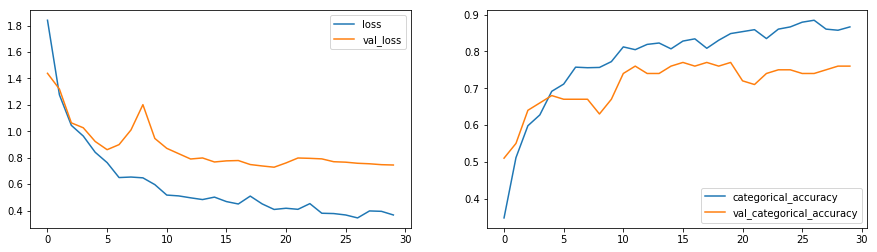

In [ ]:
plot(history_model14)

The Validation Accuracy and Training accuracy are 76% and 86% respectively after applying more data augmentation.

## Model 15 - Reducing Dense layer Neurons from 128 to 64( Similar to Model 7)

In [ ]:
class ModelConv3D15(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_169 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_169 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_250 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_153 (MaxPoolin (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_170 (Conv3D)          (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_170 (Activation)  (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_251 (Bat (None, 8, 60, 60, 32)     128       
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)
end=time.time()
end-start

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 110s 3s/step - loss: 1.8768 - categorical_accuracy: 0.3260 - val_loss: 1.6360 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-06-2902_58_51.707493/model-00001-1.90180-0.32579-1.63602-0.38000.h5
Epoch 2/25
34/34 [==============================] - 77s 2s/step - loss: 1.4102 - categorical_accuracy: 0.4562 - val_loss: 1.0925 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-06-2902_58_51.707493/model-00002-1.38020-0.45928-1.09253-0.57000.h5
Epoch 3/25
34/34 [==============================] - 101s 3s/step - loss: 1.1409 - categorical_accuracy: 0.5471 - val_loss: 1.1863 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-06-2902_58_51.707493/model-00003-1.13825-0.54827-1.18632-0.56000.h5
Epoch 4/25
34/34 [==============================] - 101s 3s/step - loss: 1.0046 - categorical_accuracy: 0.6082 - val_loss: 1.1088 - val_categor

2545.7722766399384

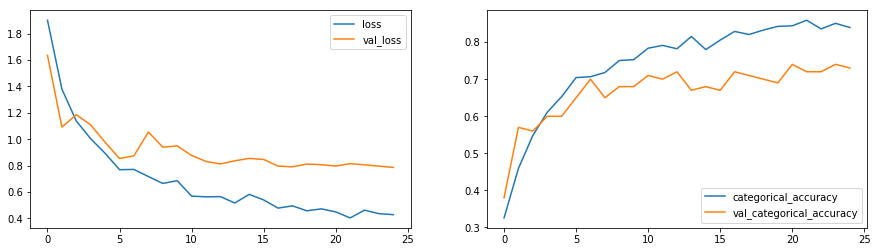

In [ ]:
plot(history_model15)

The Validation Accuracy and Training accuracy are 73% and 82.3% respectively after applying more data augmentation.

## Model 16 - Successive reduction of Conv3D Layer Neurons by half (Similar to model8)

In [ ]:
class ModelConv3D16(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_173 (Conv3D)          (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_173 (Activation)  (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_256 (Bat (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_157 (MaxPoolin (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_174 (Conv3D)          (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_174 (Activation)  (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_257 (Bat (None, 8, 60, 60, 16)     64        
__________

In [ ]:
start=time.time()
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)
end=time.time()
end-start

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 110s 3s/step - loss: 1.9076 - categorical_accuracy: 0.2921 - val_loss: 1.3723 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2903_41_18.874130/model-00001-1.93266-0.28281-1.37231-0.45000.h5
Epoch 2/30
34/34 [==============================] - 76s 2s/step - loss: 1.5144 - categorical_accuracy: 0.4128 - val_loss: 1.1110 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-06-2903_41_18.874130/model-00002-1.48784-0.42308-1.11095-0.52000.h5
Epoch 3/30
34/34 [==============================] - 99s 3s/step - loss: 1.2717 - categorical_accuracy: 0.5103 - val_loss: 0.9569 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-06-2903_41_18.874130/model-00003-1.27160-0.51056-0.95687-0.64000.h5
Epoch 4/30
34/34 [==============================] - 101s 3s/step - loss: 1.1684 - categorical_accuracy: 0.5467 - val_loss: 1.1172 - val_categori

Epoch 30/30
34/34 [==============================] - 100s 3s/step - loss: 0.6042 - categorical_accuracy: 0.7689 - val_loss: 0.7444 - val_categorical_accuracy: 0.7600

Epoch 00030: saving model to model_init_2020-06-2903_41_18.874130/model-00030-0.58977-0.77979-0.74437-0.76000.h5


3045.5930955410004

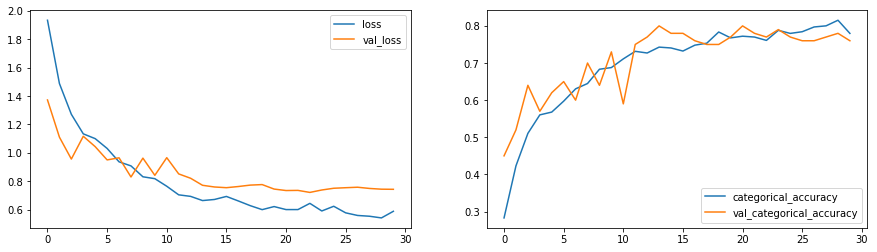

In [ ]:
plot(history_model16)

The Validation Accuracy and Training accuracy are 76% and 76.89% respectively after applying more data augmentation.

## Model 17 - CNN LSTM with GRU - Similar to Model 9

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [ ]:
start=time.time()
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)
end=time.time()
end-start

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 123s 4s/step - loss: 1.4953 - categorical_accuracy: 0.3528 - val_loss: 1.3113 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2904_32_05.685624/model-00001-1.50280-0.34917-1.31125-0.45000.h5
Epoch 2/20
34/34 [==============================] - 89s 3s/step - loss: 1.1338 - categorical_accuracy: 0.5464 - val_loss: 1.1202 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-06-2904_32_05.685624/model-00002-1.12644-0.54751-1.12019-0.49000.h5
Epoch 3/20
34/34 [==============================] - 112s 3s/step - loss: 0.9513 - categorical_accuracy: 0.6218 - val_loss: 0.9561 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-06-2904_32_05.685624/model-00003-0.94403-0.63725-0.95608-0.66000.h5
Epoch 4/20
34/34 [==============================] - 113s 3s/step - loss: 0.7927 - categorical_accuracy: 0.7185 - val_loss: 0.9125 - val_catego

2279.3606975078583

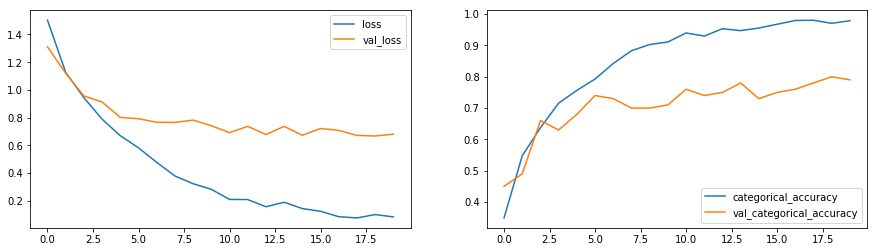

In [ ]:
plot(history_model17)

The Validation Accuracy and Training accuracy are 79% and 97% respectively after applying more data augmentation.

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

## Model 18 - Transfer Learning

In [ ]:
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_93 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 128)               16512     
__________

In [ ]:
start=time.time()
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)
end=time.time()
end-start

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 114s 855ms/step - loss: 1.4734 - categorical_accuracy: 0.3549 - val_loss: 1.3960 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-06-2910_09_42.602935/model-00001-1.47436-0.35445-1.39596-0.45000.h5
Epoch 2/20
133/133 [==============================] - 96s 720ms/step - loss: 1.2430 - categorical_accuracy: 0.4855 - val_loss: 1.2908 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-06-2910_09_42.602935/model-00002-1.24449-0.48492-1.29078-0.52000.h5
Epoch 3/20
133/133 [==============================] - 104s 785ms/step - loss: 0.9863 - categorical_accuracy: 0.6185 - val_loss: 1.1361 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-06-2910_09_42.602935/model-00003-0.98618-0.61840-1.13609-0.54000.h5
Epoch 4/20
133/133 [==============================] - 102s 770ms/step - loss: 0.9346 - categorical_accuracy: 0.6266 - val_loss:

2086.22869682312

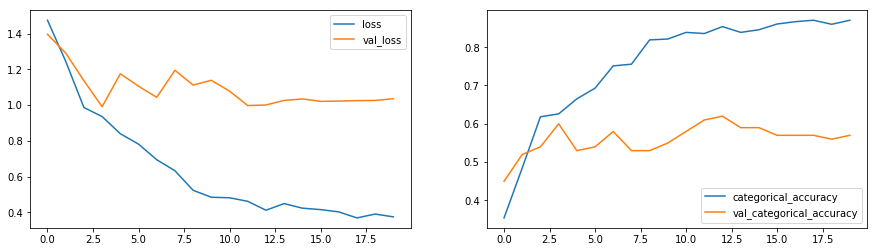

In [ ]:
plot(history_model18)

The Validation Accuracy and Training accuracy are 56% and 87% respectively after applying more data augmentation.
- We are not training the mobilenet weights and we see validation accuracy is very poor.
- Let's train them as well and observe if there is performance improvement

## Model 19 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_95 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 128)               16512     
__________

In [ ]:
start=time.time()
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)
end=time.time()
end-start

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 121s 907ms/step - loss: 1.3320 - categorical_accuracy: 0.4632 - val_loss: 0.6729 - val_categorical_accuracy: 0.7500

Epoch 00001: saving model to model_init_2020-06-2910_44_49.204586/model-00001-1.33197-0.46305-0.67288-0.75000.h5
Epoch 2/20
133/133 [==============================] - 99s 742ms/step - loss: 0.7210 - categorical_accuracy: 0.7361 - val_loss: 0.3795 - val_categorical_accuracy: 0.8600

Epoch 00002: saving model to model_init_2020-06-2910_44_49.204586/model-00002-0.72049-0.73680-0.37953-0.86000.h5
Epoch 3/20
133/133 [==============================] - 104s 784ms/step - loss: 0.5766 - categorical_accuracy: 0.7895 - val_loss: 0.4835 - val_categorical_accuracy: 0.7400

Epoch 00003: saving model to model_init_2020-06-2910_44_49.204586/model-00003-0.57369-0.79035-0.48346-0.74000.h5
Epoch 4/20
133/133 [==============================] - 104s 783ms/step - loss: 0.4749 - categorical_accuracy: 0.8178 - val_loss:

2149.7695598602295

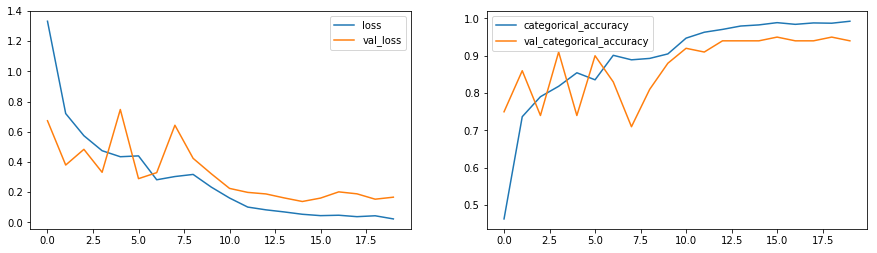

In [ ]:
plot(history_model19)

The Validation Accuracy and Training accuracy are 95% and 98.8% respectively after making the mobilenet weights trainable.

# Consolidated Final Models

![image.png](attachment:image.png)

If Validation Accuracy is our priority, <br> We may choose to use GRU model using Transfer Learning having trainable weights(Model 19), this model has 94% Validation Accuracy.

![image.png](attachment:image.png)

If less Model footprint is our priority, <BR>
We may choose to use Data Augmented Vesion of the Conv 3D Model having 64 dense layer neurons (model 16) <br>this model has validation accuracy of 76%.

![image.png](attachment:image.png)

##### Finally we choose to test model 19 and 16 based on Accuracy and Model Compactness

# Loading model and Testing

### A) Loading and testing model 19

In [ ]:
import time
from keras.models import load_model
model = load_model('model_init_2020-06-2910_44_49.204586/model-00020-0.02261-0.99246-0.16654-0.94000.h5')

In [ ]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4 4 2 3 3]


### B) Loading and testing model 16

In [ ]:
import time
from keras.models import load_model
model = load_model('model_init_2020-06-2903_41_18.874130/model-00030-0.58977-0.77979-0.74437-0.76000.h5')

In [ ]:
test_generator=ModelConv3D16()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 3 1 4 1 3 3 4 3 3 1 4 1 0 3 2 2 4 0]
